# Stacking Sats: Optimal Bitcoin Accumulation Strategy
## Executive Summary: Exploratory Data Analysis 

**Part 1: Timing | Part 2: On-Chain Valuation | Part 3: Sentiment**

Team 24: Thishan Sivakumar (tsivakumar6)

---

## Research Overview

**Question:** Can we improve simple Dollar-Cost Averaging (DCA) into Bitcoin by incorporating timing rules, on-chain valuation metrics, or prediction-market sentiment?

| Part | Focus | Data Source | Coverage |
|------|-------|-------------|----------|
| **Part 1** | Timing: Does *when* / *how often* you buy matter? | Coin Metrics BTC on-chain | 2010-2025 |
| **Part 2** | Valuation: Can MVRV & NVT signals improve DCA efficiency? | Coin Metrics BTC on-chain | 2010-2025 |
| **Part 3** | Sentiment: Do Polymarket crowd predictions add value? | Polymarket prediction markets | 2023-2026 |

---

## Methodology Overview

### Part 1: Timing Analysis
- **174 rolling 12-month windows**, sliding by 1 month across the full BTC price history
- DCA simulation engine: daily / weekly / biweekly at $10/event
- Weekday, month, day-of-month grouping with calendar feature engineering
- **Kruskal-Wallis H-test** (non-parametric) with $\eta^2$ effect size reporting
- Weekday × Month interaction heatmap for combined effects

### Part 2: On-Chain Valuation
- **MVRV Z-Score** and **NVT proxy** as valuation market state indicators
- Composite signal: averaged MVRV + NVT z-scores
- Dynamic DCA: scale buy amounts by valuation market state (e.g., 1.5× / 1.0× / 0.5×)
- Sensitivity analysis across multiplier profiles (conservative → aggressive)
- Forward 30d/90d return analysis by valuation bucket

### Part 3: Sentiment Signals
- ~30 daily features from Polymarket BTC prediction markets
- Feature construction: odds levels, breadth, dispersion, momentum, volume, divergence
- **Five ranking methods:** Spearman $\rho$, RF/GB importance, Mutual Information, Lasso/ElasticNet, lag analysis
- Time-lagged cross-correlation (−14 to +14 days) for lead/lag classification

---

## Preliminary Data Checks

Before any analysis, both data sources were validated for integrity, completeness, and domain correctness. Full details are in the companion **Data Integrity Checks** notebook.

### Coin Metrics (BTC On-Chain)
- **6,221 rows** with continuous daily coverage from **2009-01-03 → 2026-01-14**, no date gaps, no duplicates
- 31 of 33 columns have some nulls, but the **562 nulls** in most EDA-critical columns (`PriceUSD`, `CapMVRVCur`, etc.) are associated with early BTC days before exchanges existed, **reasonable, not a quality issue**
- All domain constraints pass: no negative prices, MVRV ratios, or hash rates

### Polymarket (Prediction Markets)
- All **6 parquet files** loaded; **zero duplicate records** across all primary keys



---

## Part 1: Time-of-Purchase Results

> **Key takeaway:** DCA's systematic discipline is far more important than timing. No purchase-timing rule reliably beats uniform DCA across 15+ years and 174 rolling windows.

### 1. Frequency (Daily vs Weekly vs Biweekly) → Negligible Difference

| Frequency | Mean ROI | Median ROI | Mean Avg Cost |
|-----------|----------|------------|---------------|
| **Biweekly** | 185.0% | 45.0% | $15,891 |
| **Weekly** | 181.0% | 44.0% | $15,952 |
| **Daily** | 180.7% | 44.1% | $15,944 |

All three frequencies produce nearly identical outcomes. The spread in mean ROI is only ~4 percentage points, well within the standard deviation (~657%). **The choice of cadence does not significantly affect long-term accumulation outcomes.**

### 2. Weekday Buy-Day Effects → Statistically Insignificant
- **Best day:** Sunday (mean avg cost \$15,924, mean ROI 182.0%)
- **Worst day:** Wednesday (mean avg cost \$15,984, mean ROI 181.1%)
- **Spread:** Only **0.38%** between best and worst day
- **Kruskal-Wallis:** H = 8.76, **p = 0.187** (not significant), $\eta^2$ = 0.0005 (negligible)

### 3. Monthly Seasonality → Statistically Insignificant
- Strongest months: April (+0.81%), October (+0.64%), November (+0.63%)
- Weakest months: September (−0.09%), August (−0.03%)
- **Kruskal-Wallis:** H = 15.06, **p = 0.180** (not significant), $\eta^2$ = 0.0007 (negligible)

The "September effect" and "Q4 rally" are visible but **not statistically significant**. High variance in BTC daily returns (~4–6% std) dwarfs monthly mean differences.

### 4. Day-of-Month Effects → Significant but Negligible Effect
- **Kruskal-Wallis:** H = 68.46, **p = 0.00008*** (significant), $\eta^2$ = 0.007 (negligible)

Statistical significance driven by large sample (5,659 obs), but actual effect size is negligible and not economically meaningful.

Part 1: DCA Cadence Comparison (Daily vs Weekly vs Biweekly)


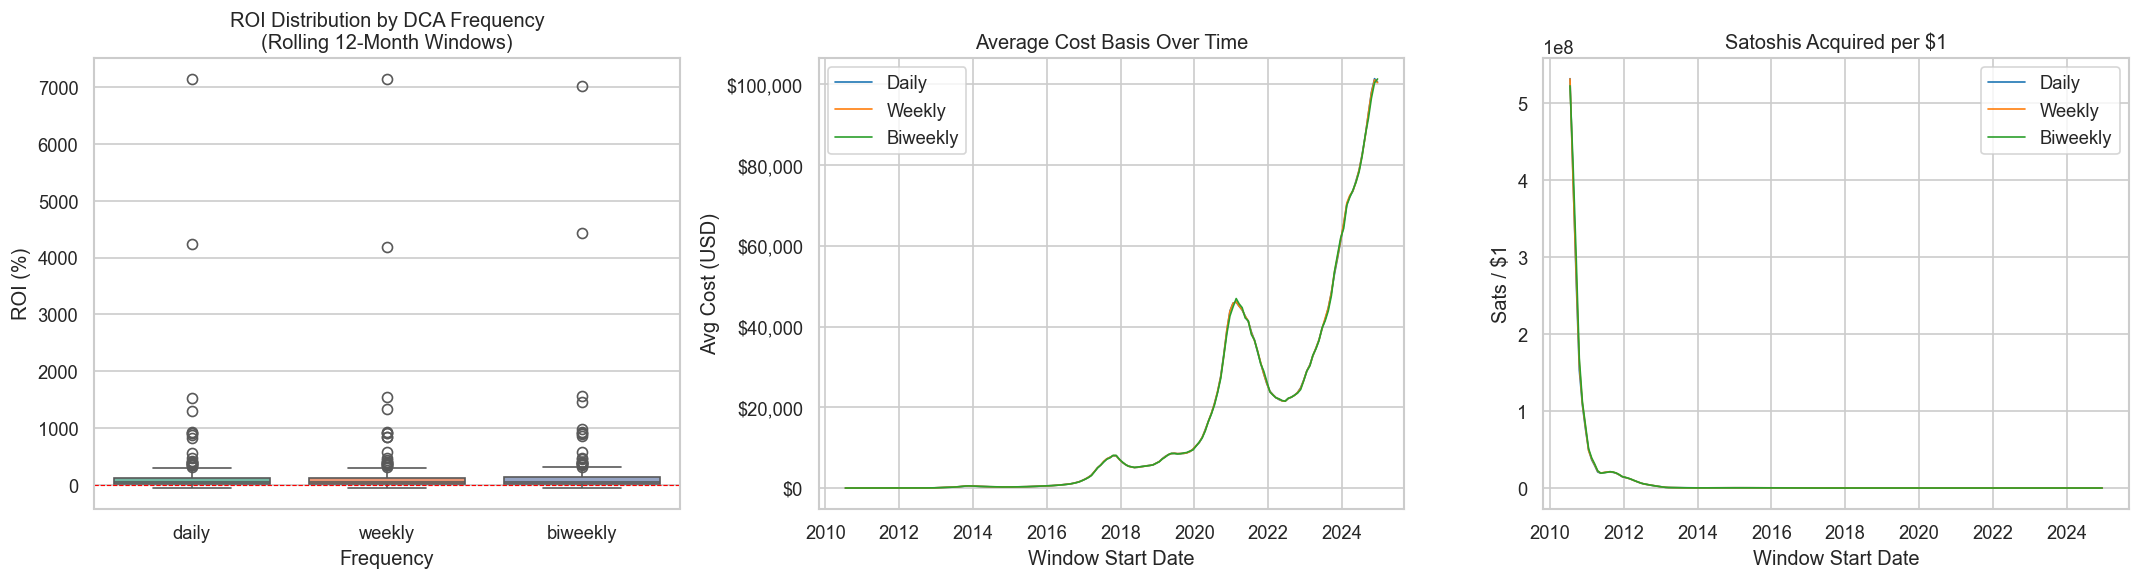

In [20]:
from pathlib import Path
from IPython.display import Image, display

PLOTS_DIR = Path("plots")

print("Part 1: DCA Cadence Comparison (Daily vs Weekly vs Biweekly)")
display(Image(filename=str(PLOTS_DIR / "dca_cadence_comparison.png"), width=900))

Part 1: Weekday Buy-Day Effect


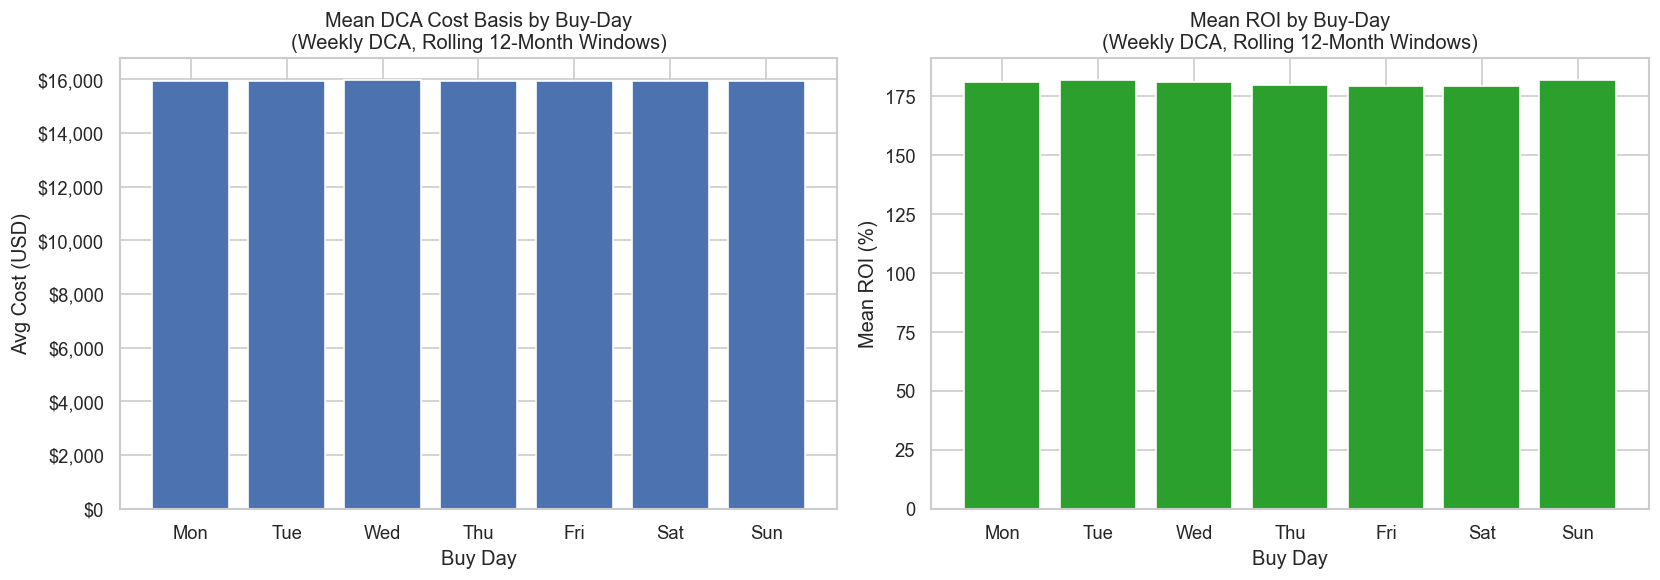

In [21]:
print("Part 1: Weekday Buy-Day Effect")
display(Image(filename=str(PLOTS_DIR / "weekday_dca_effect.png"), width=800))

Part 1: Monthly Seasonality


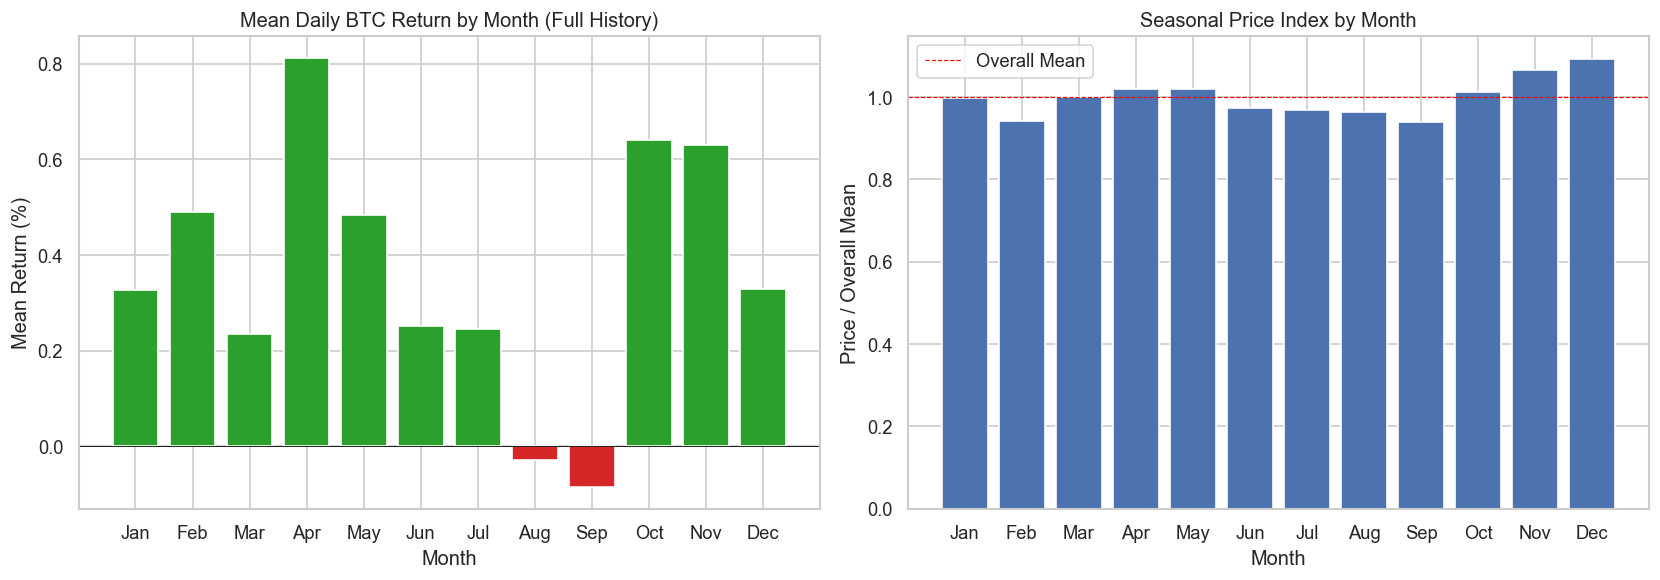

In [22]:
print("Part 1: Monthly Seasonality")
display(Image(filename=str(PLOTS_DIR / "monthly_seasonality.png"), width=800))

Part 1: Weekday × Month Interaction Heatmap


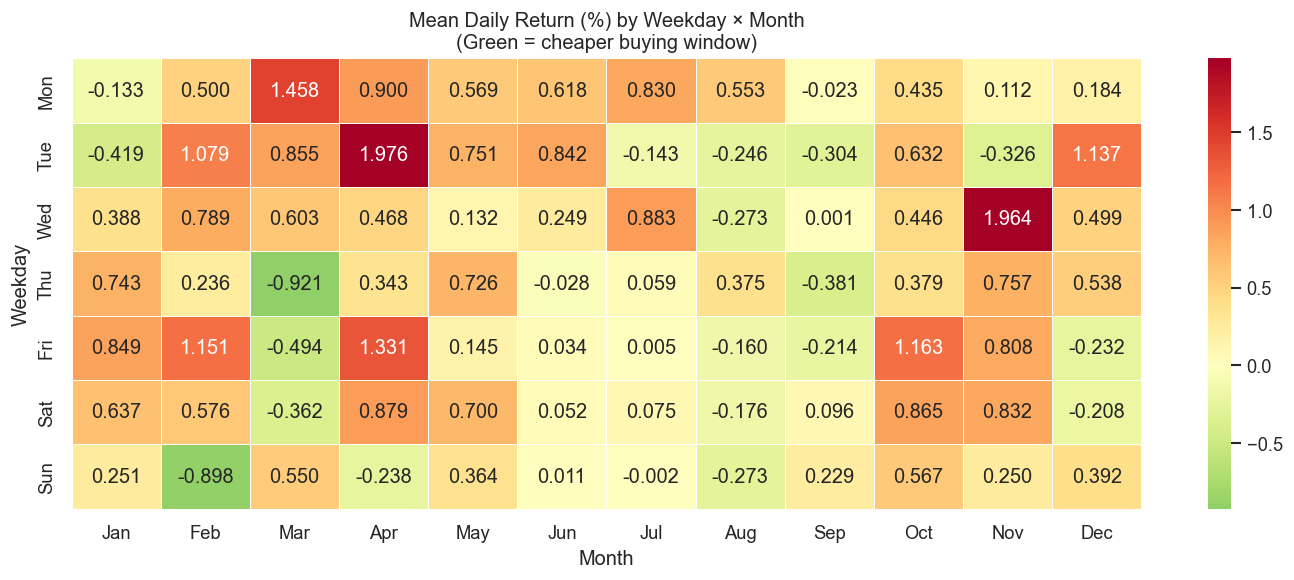

In [23]:
print("Part 1: Weekday × Month Interaction Heatmap")
display(Image(filename=str(PLOTS_DIR / "weekday_month_heatmap.png"), width=800))

---

## Part 2: On-Chain Valuation Signals Results

### Signal Quality

| Signal | Observation |
|--------|-------------|
| **MVRV** | MVRV < 1.0 historically marks accumulation zones with highest forward 30d/90d returns |
| **NVT proxy** | Noisier than MVRV; 14-day smoothing helps but spot-volume denominator introduces distortion |
| **Composite (MVRV + NVT)** | Averaged z-scores provide balanced market state identification |
| **MVRV vs NVT** | MVRV-only is the stronger single signal; NVT adds diversification at cost of false market state shifts |

### Dynamic DCA Performance

- Dynamic DCA shows **positive but modest** mean BTC advantage vs uniform DCA
- Win rate exceeds 50% across rolling 12-month windows
- **Aggressive profiles** (2.5×/0.0×) amplify upside AND downside
- **Moderate profiles** (1.5×/1.0×/0.5×) offer the best risk/reward tradeoff

> **Key takeaway:** Buying more when MVRV signals undervaluation tends to lower average cost basis, but the improvement is modest. Extreme multiplier configs risk under-deploying capital during prolonged bull runs. Moderate profiles balance the tradeoff.

Part 2: MVRV Exploratory Analysis


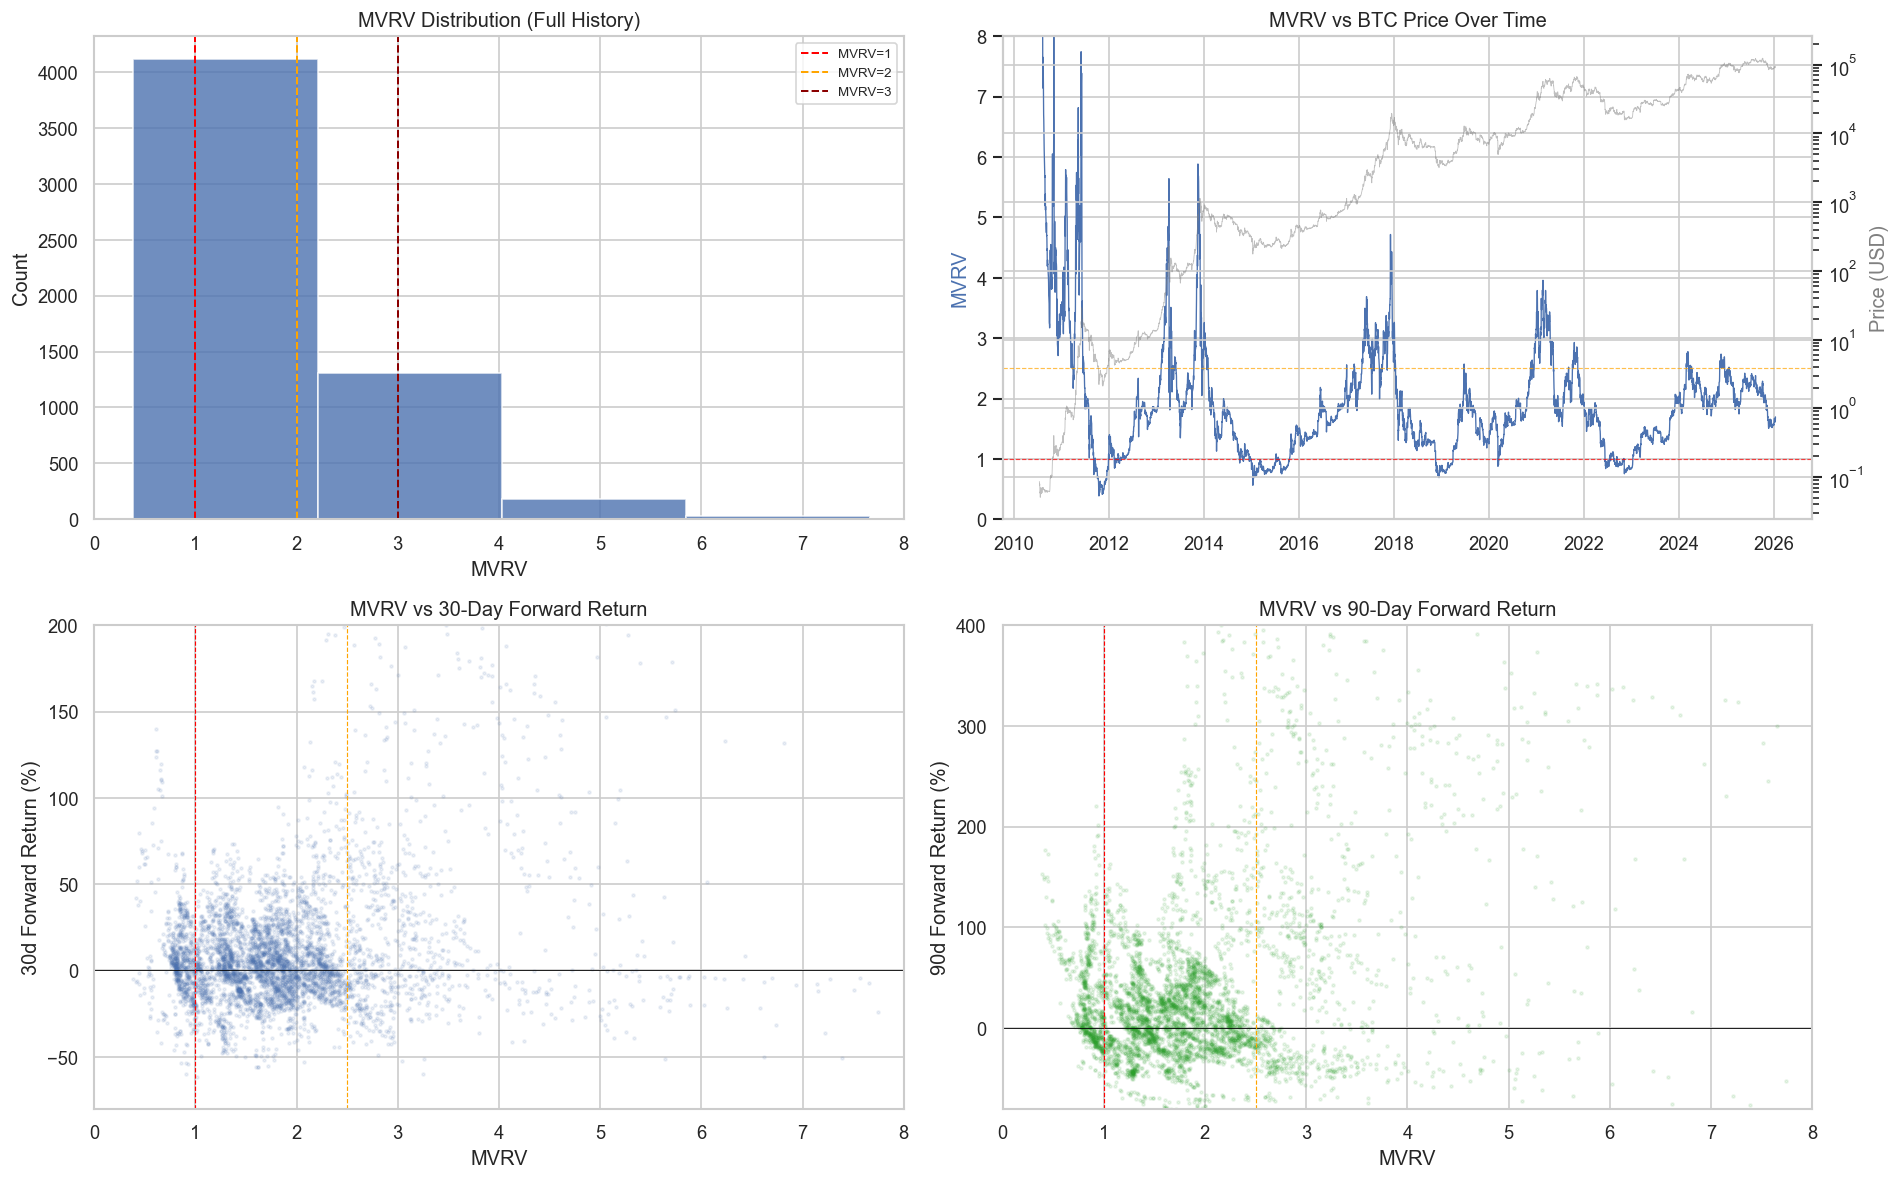

In [24]:
print("Part 2: MVRV Exploratory Analysis")
display(Image(filename=str(PLOTS_DIR / "mvrv_eda.png"), width=900))

Part 2: NVT Exploratory Analysis


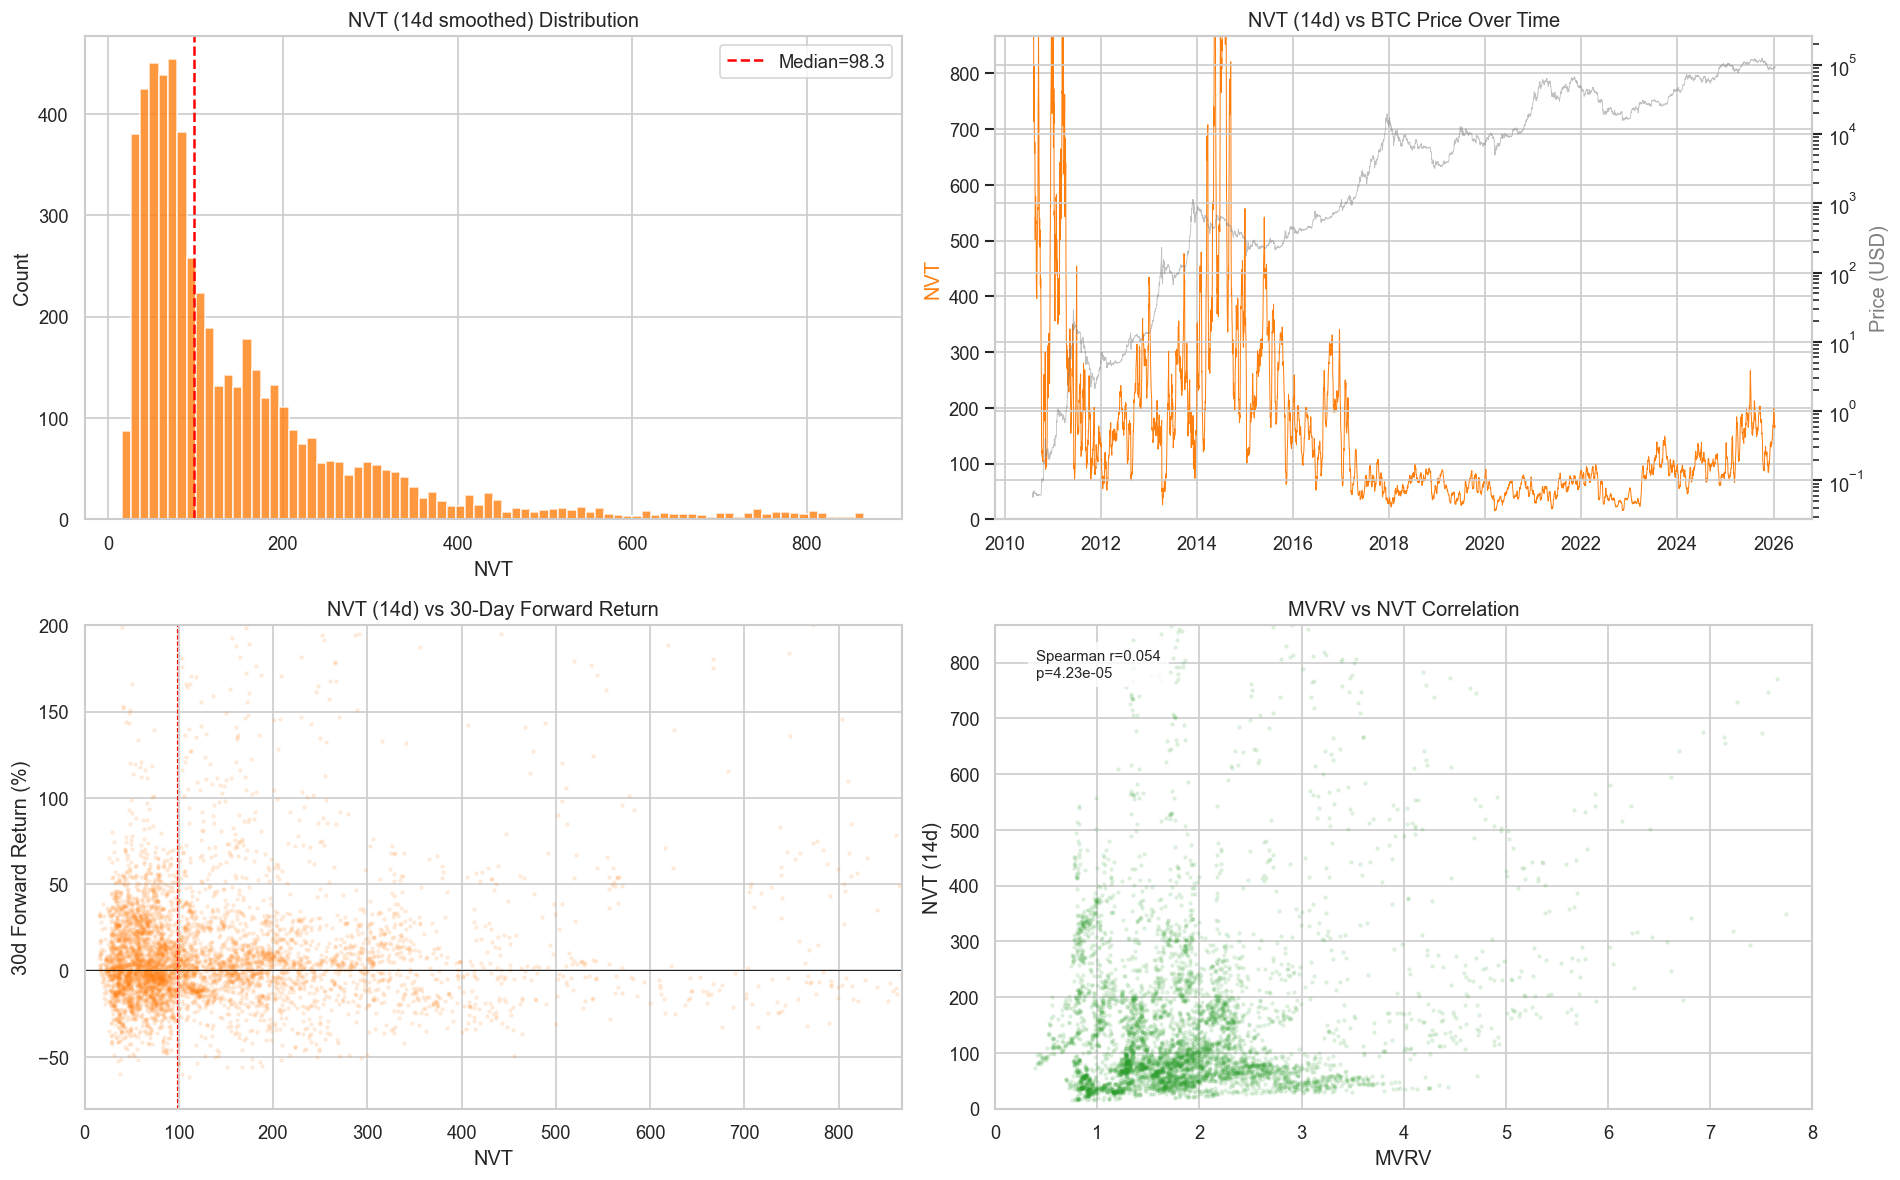

In [25]:
print("Part 2: NVT Exploratory Analysis")
display(Image(filename=str(PLOTS_DIR / "nvt_eda.png"), width=900))

Part 2: Valuation Market States


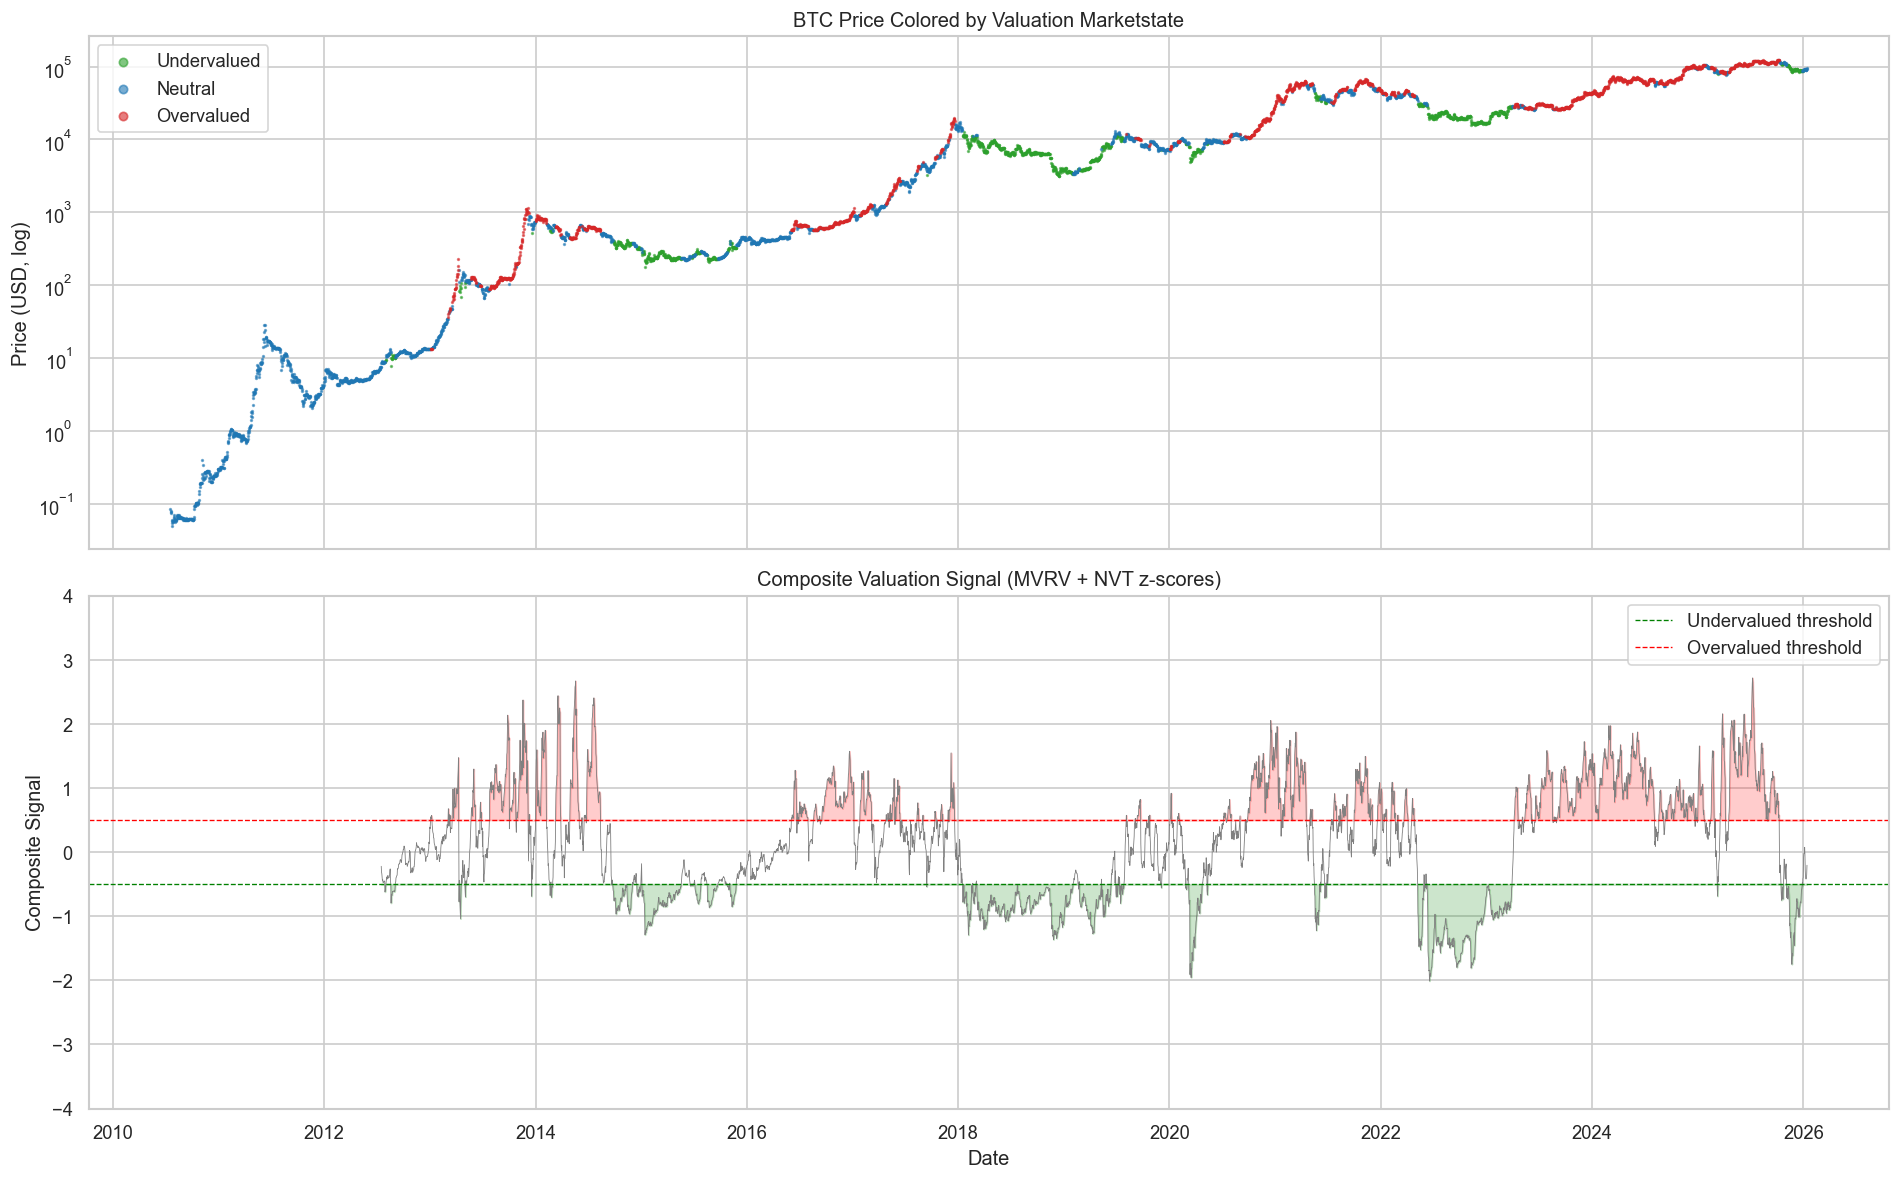

In [26]:
print("Part 2: Valuation Market States")
display(Image(filename=str(PLOTS_DIR / "valuation_marketstate.png"), width=900))

Part 2: MVRV Bucket Forward Returns


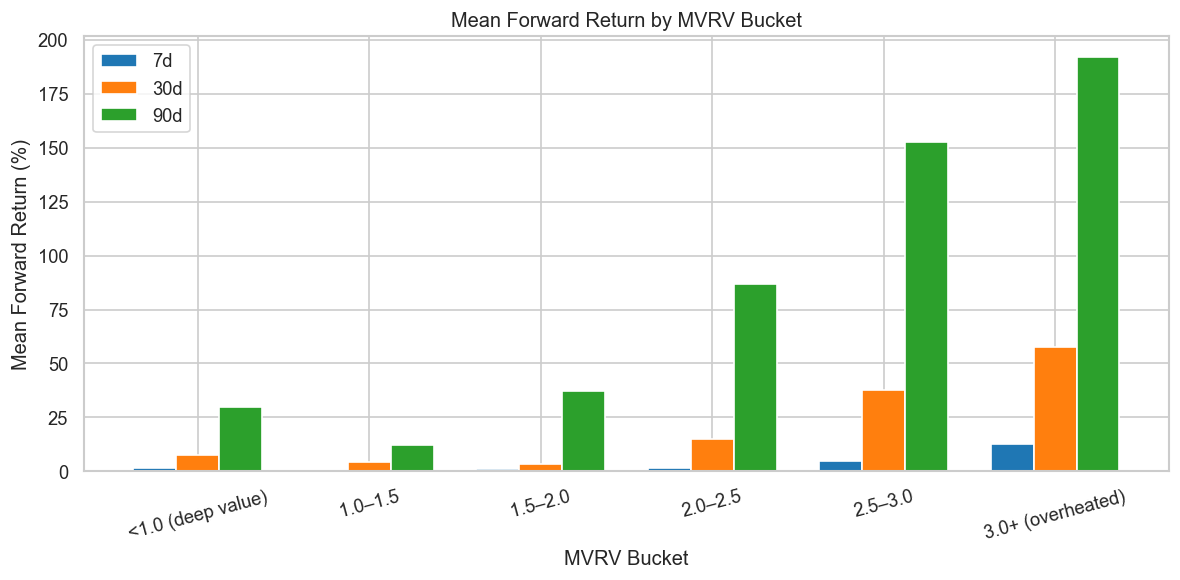

In [27]:
print("Part 2: MVRV Bucket Forward Returns")
display(Image(filename=str(PLOTS_DIR / "mvrv_bucket_returns.png"), width=900))

Part 2: Dynamic DCA Strategy Dashboard


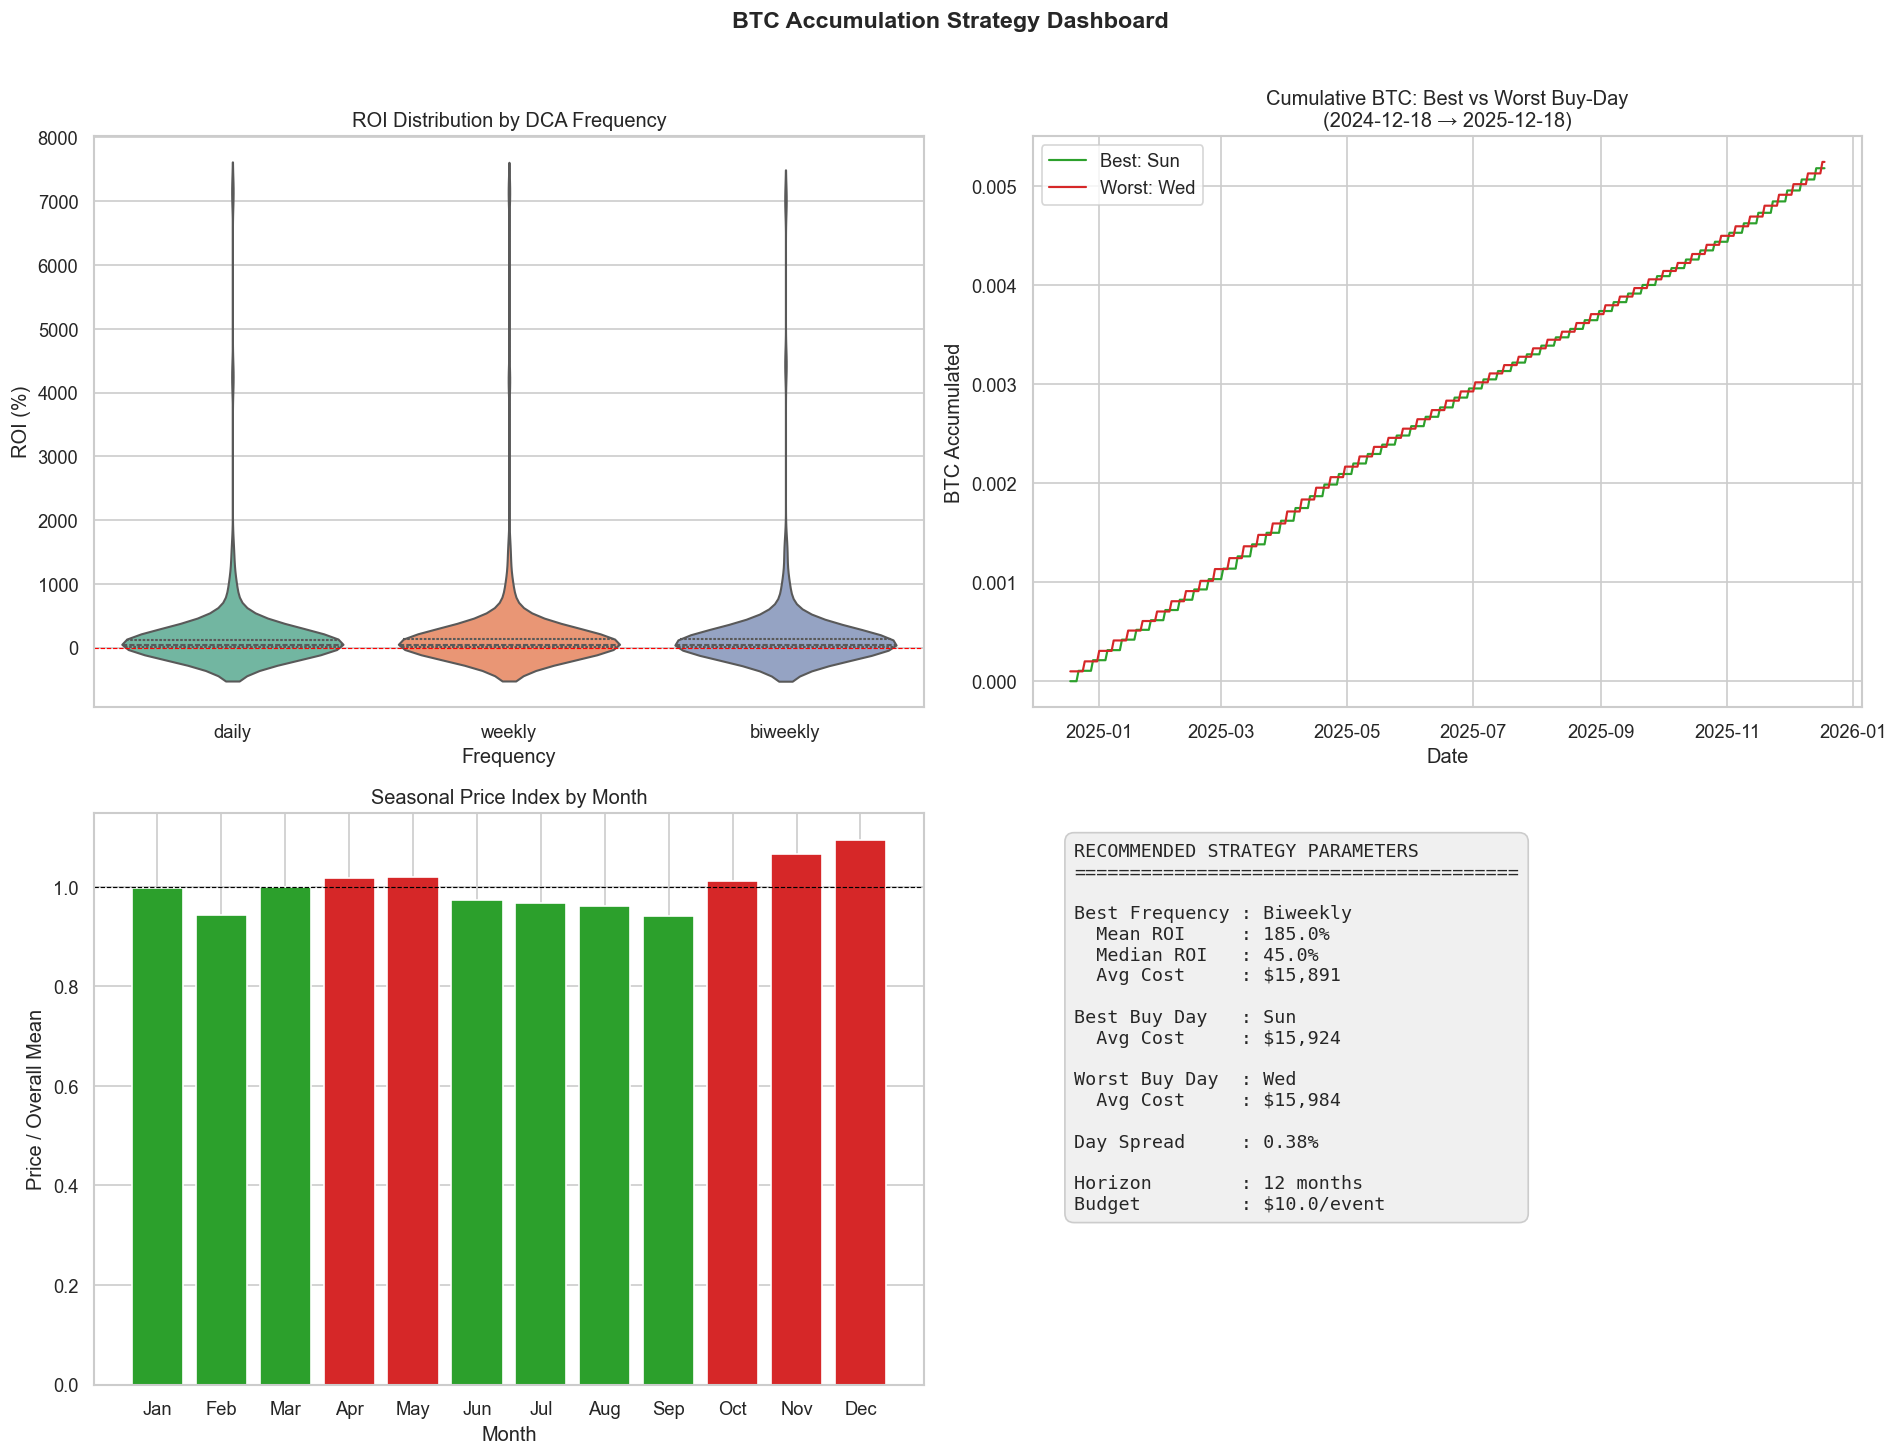

In [28]:
print("Part 2: Dynamic DCA Strategy Dashboard")
display(Image(filename=str(PLOTS_DIR / "strategy_dashboard.png"), width=900))

---

## Part 3: Polymarket Sentiment Results

### Feature Construction
- ~30 daily features: odds levels, breadth, dispersion, activity, volume, momentum
- Sentiment–price divergence: crowd bullish but price dropping (or vice versa)
- Rolling windows (7d/14d/30d) to smooth noisy daily signals
- Yes-token prices used as crowd probability estimates for binary BTC markets

### Predictive Power Assessment

| Method | Finding |
|--------|---------|
| **Spearman correlation** | \|$\rho$\| with 7d forward returns typically < 0.1, weak linear relationships |
| **Tree-based models** | Cross-validated accuracy: ~50–53%, weak accuracy |
| **Mutual Information** | Non-zero but small; marginal non-linear signal |
| **Lasso / ElasticNet** | Heavy regularization zeros out most features |
| **Lead/lag analysis** | Odds momentum & breadth momentum peak at **negative lags**, leading indicators |

> **Key takeaway:** No single Polymarket feature is a strong standalone predictor of BTC returns. `odds_mean_momentum_7d` shows agreement across all 5 methods but has a weak effect. Only lead/lag analysis identifies actionable leading indicators. The short data window (2023–2026) limits generalizability.

Part 3: Polymarket Feature Distributions


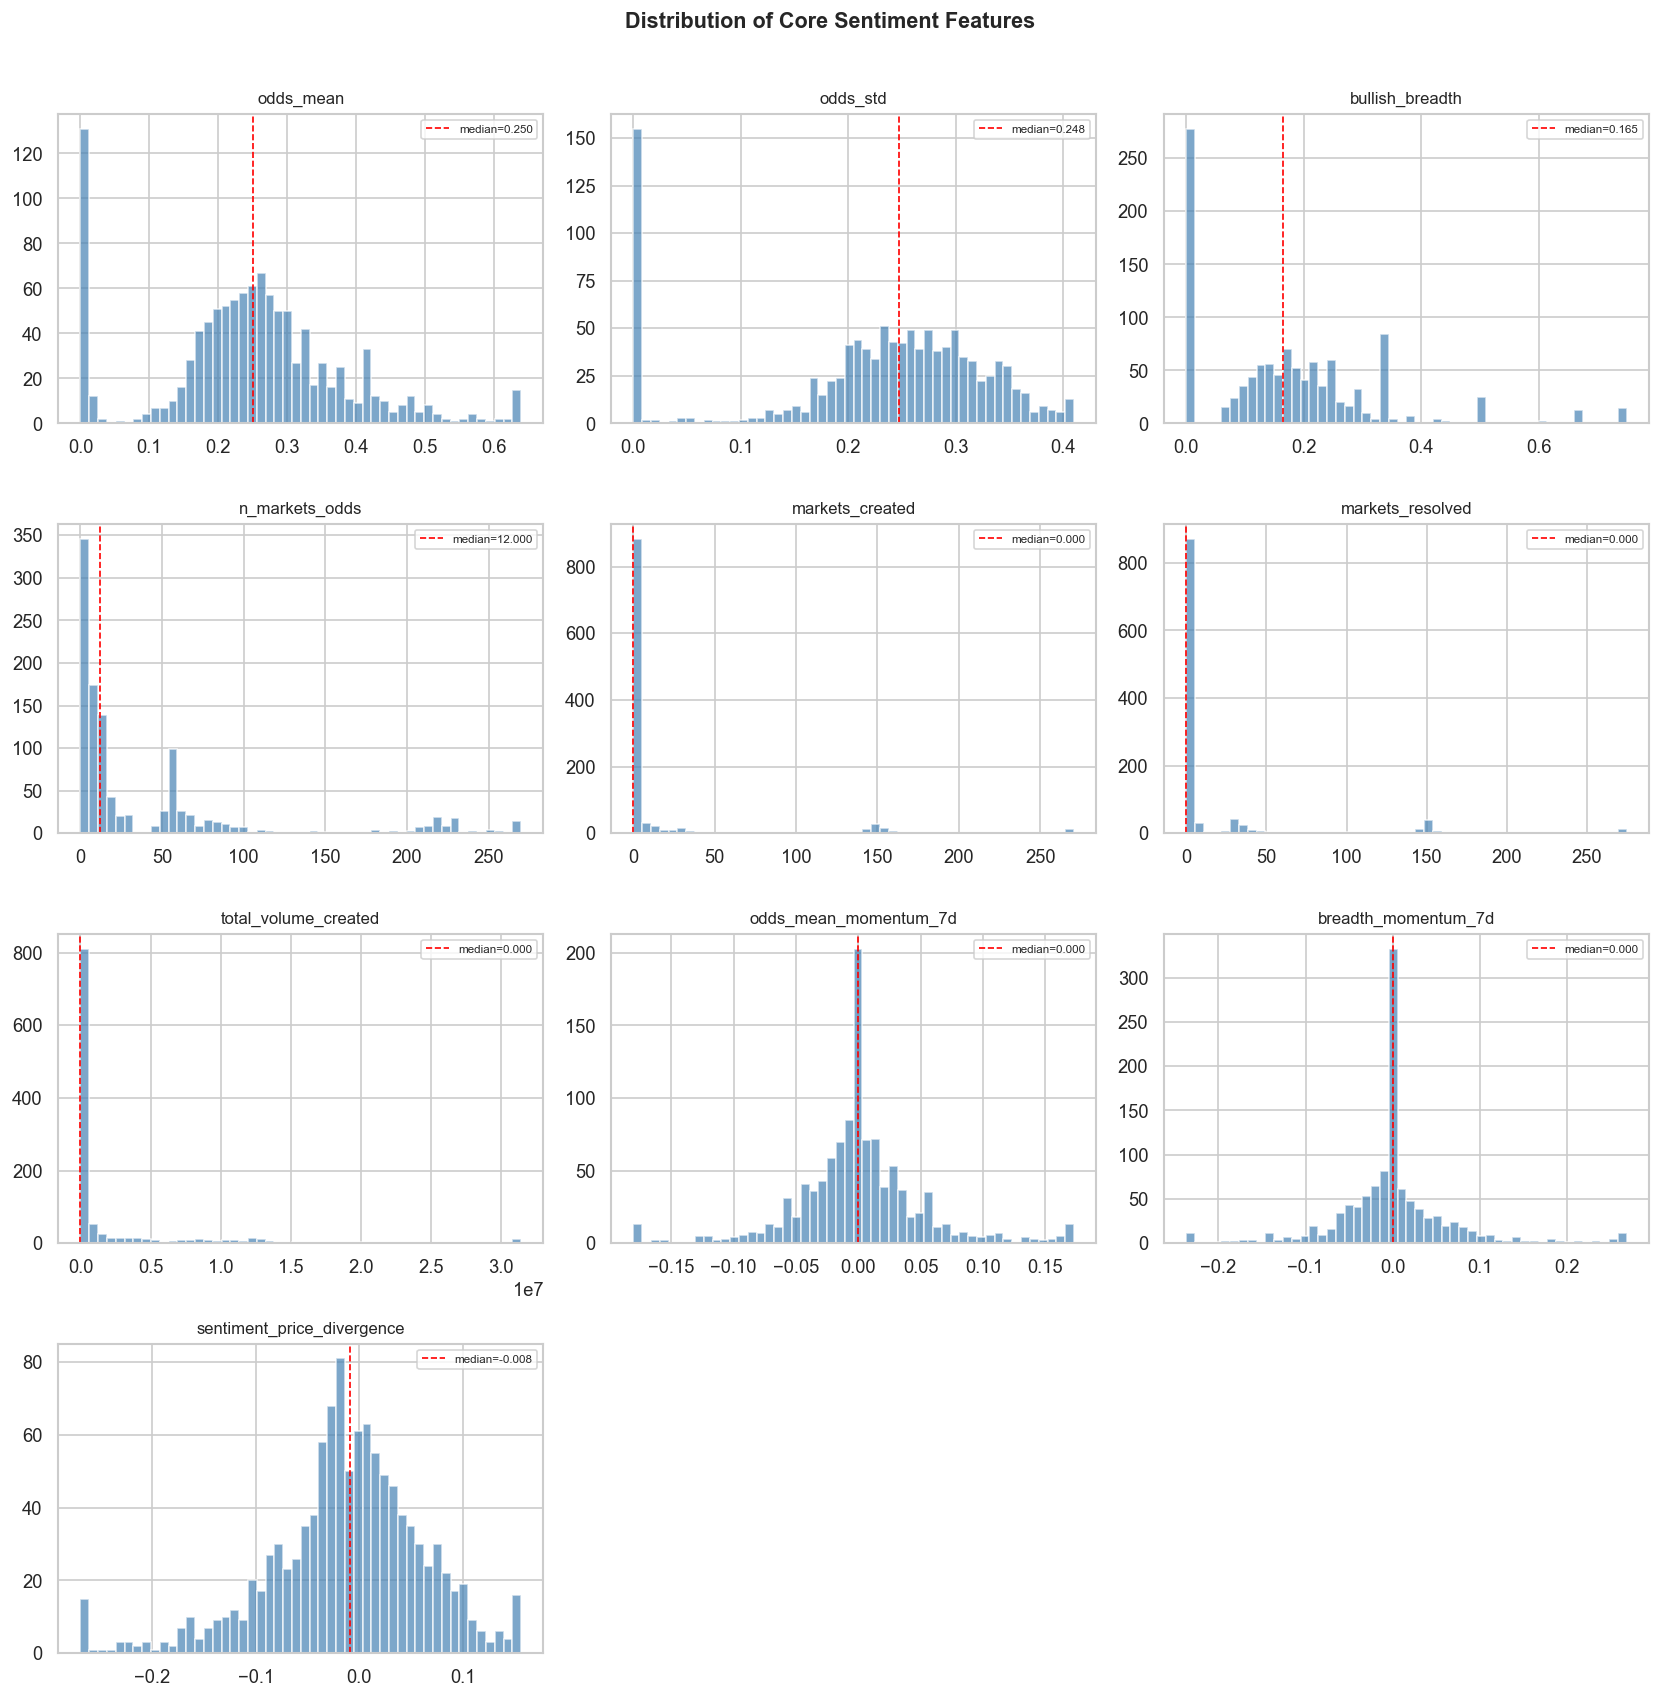

In [29]:
print("Part 3: Polymarket Feature Distributions")
display(Image(filename=str(PLOTS_DIR / "part3_feature_distributions.png"), width=900))

Part 3: Correlation Heatmap


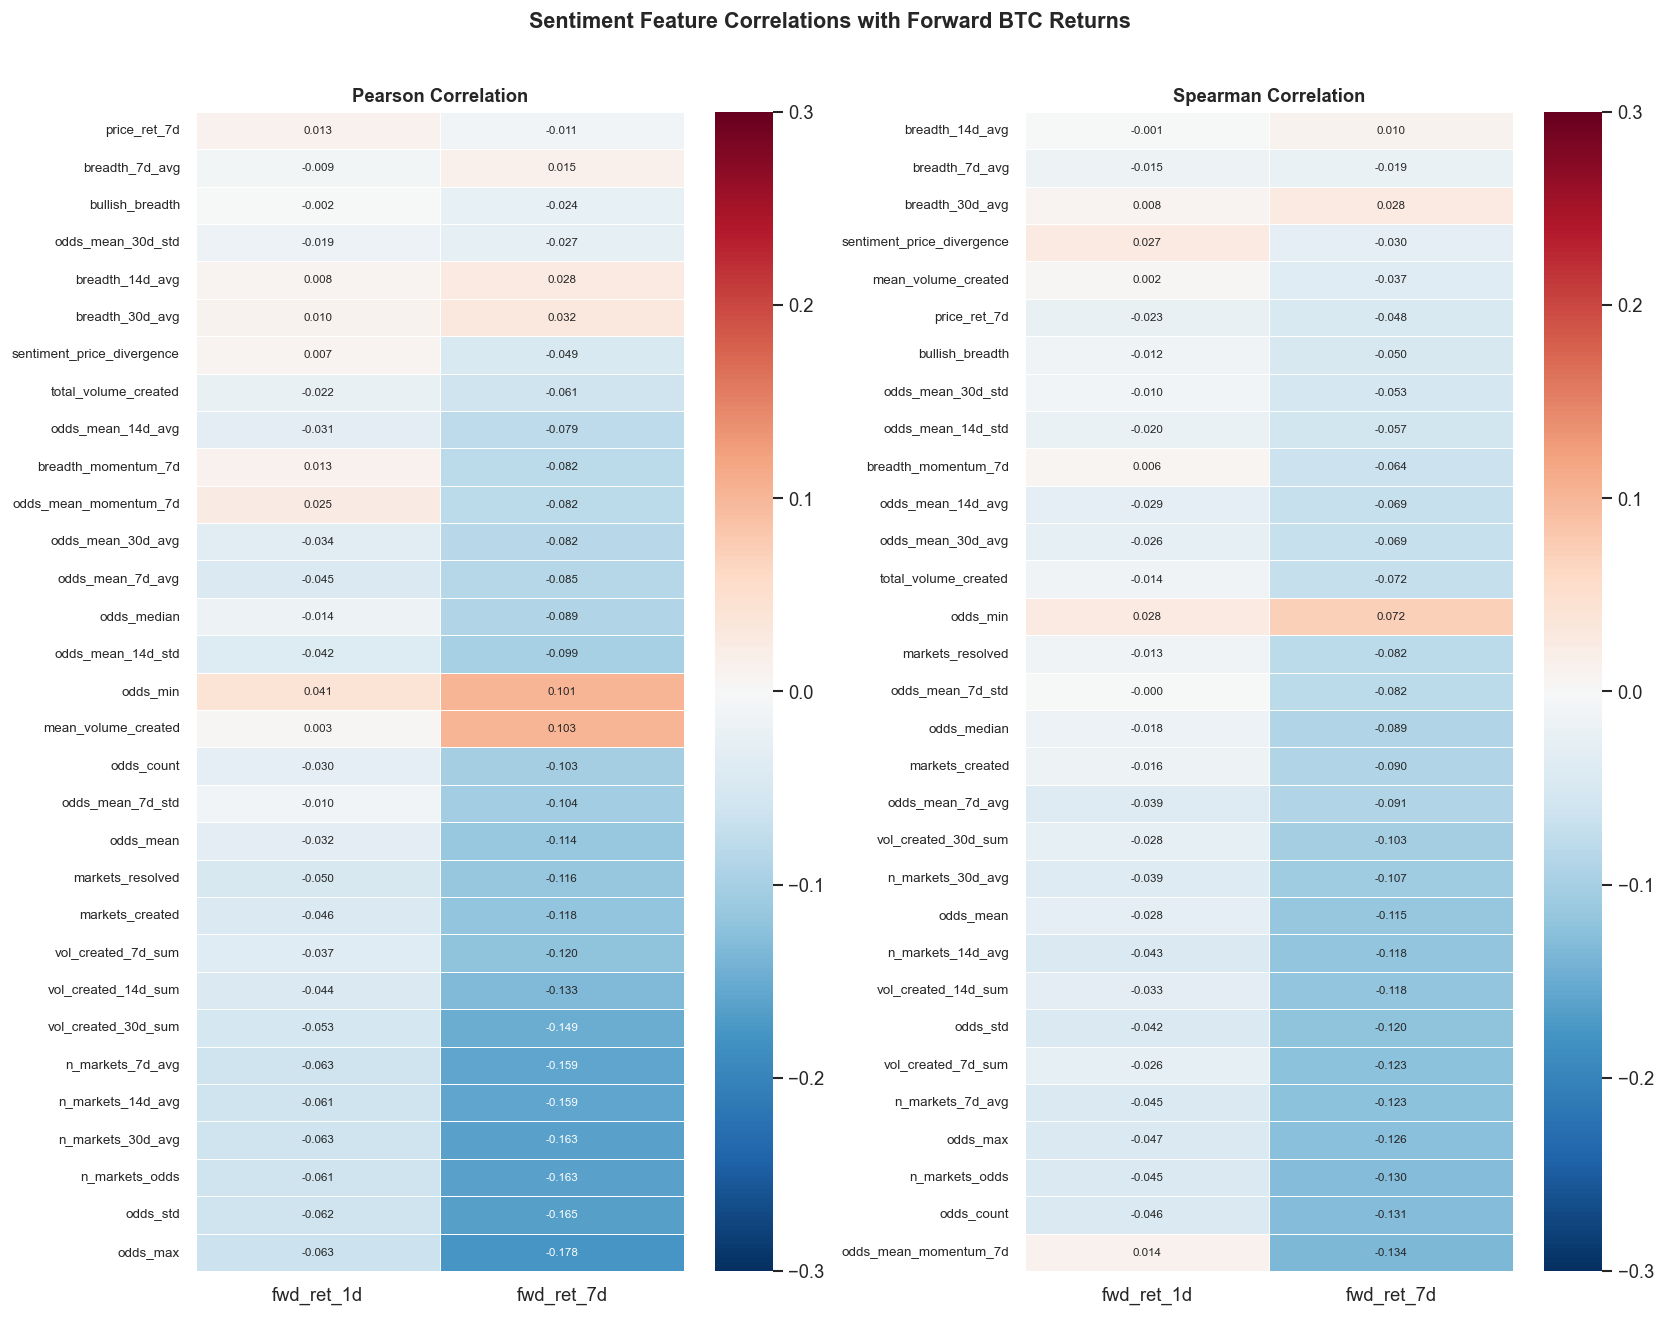

In [30]:
print("Part 3: Correlation Heatmap")
display(Image(filename=str(PLOTS_DIR / "part3_correlation_heatmap.png"), width=900))

Part 3: Tree-Based Feature Importance (RF & GBM)


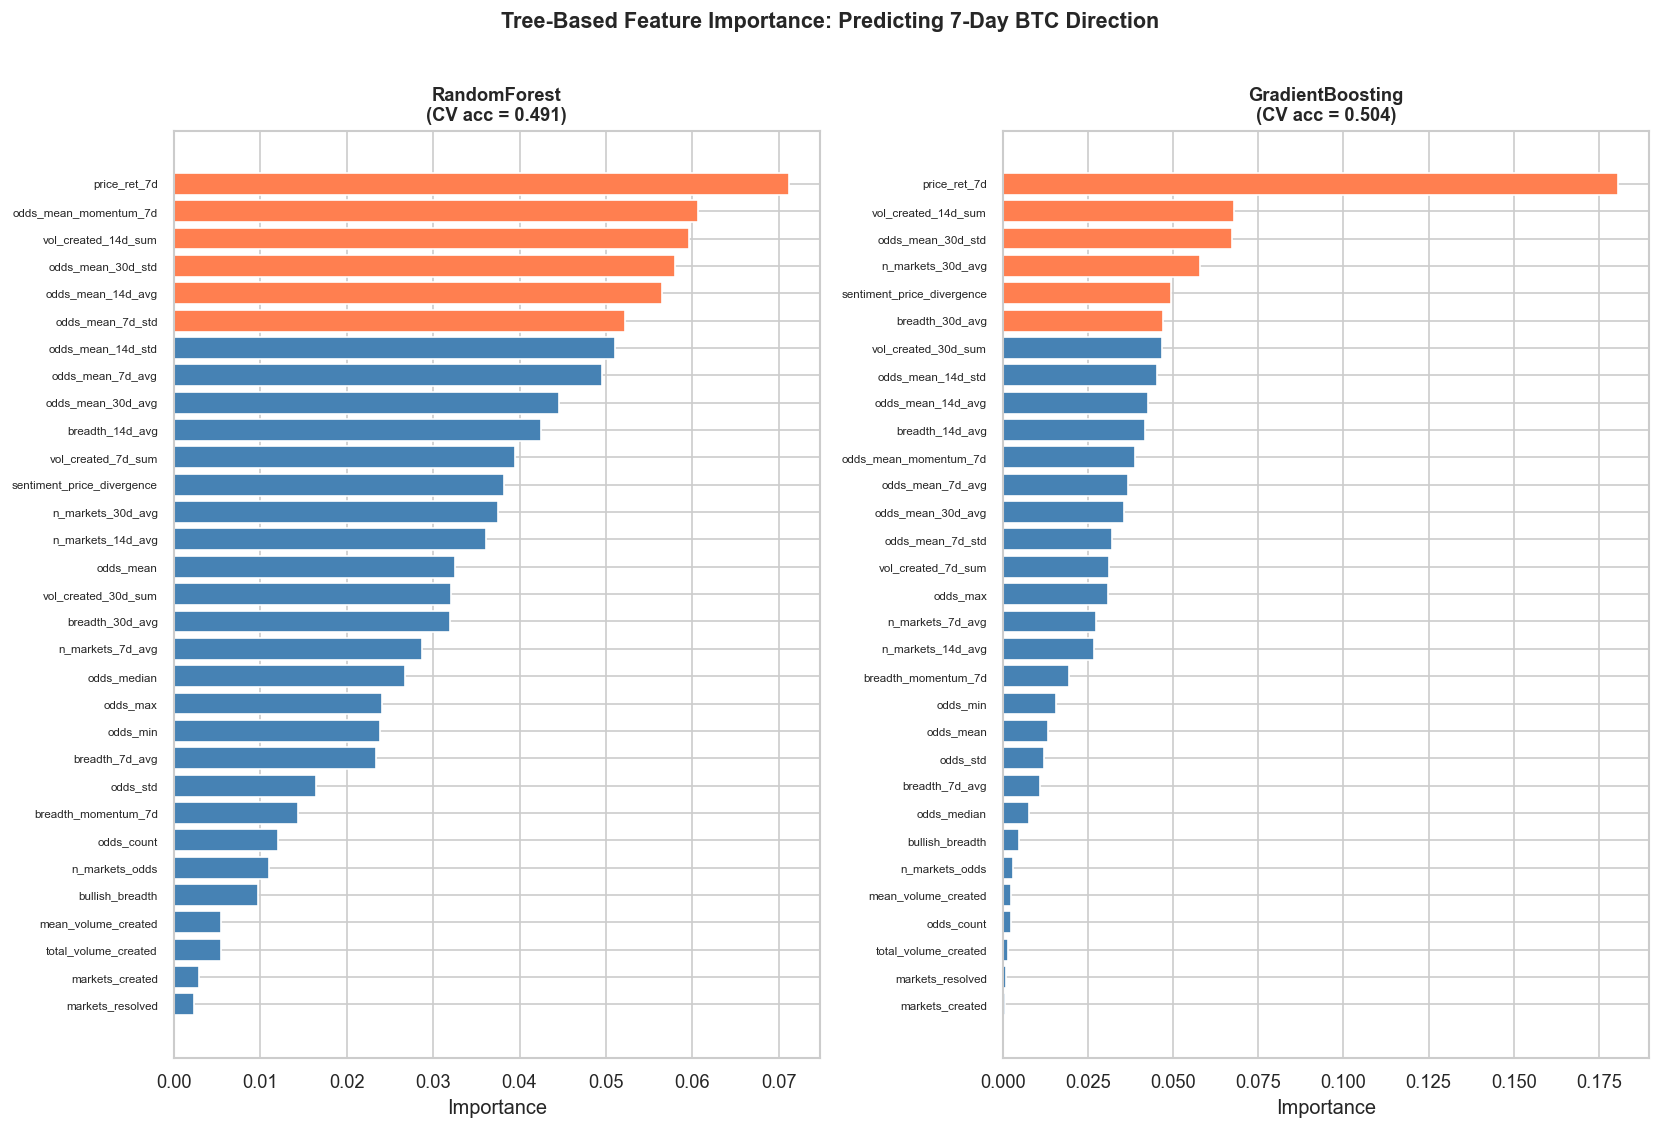

In [31]:
print("Part 3: Tree-Based Feature Importance (RF & GBM)")
display(Image(filename=str(PLOTS_DIR / "part3_tree_importance.png"), width=900))

Part 3: Mutual Information & F-Test


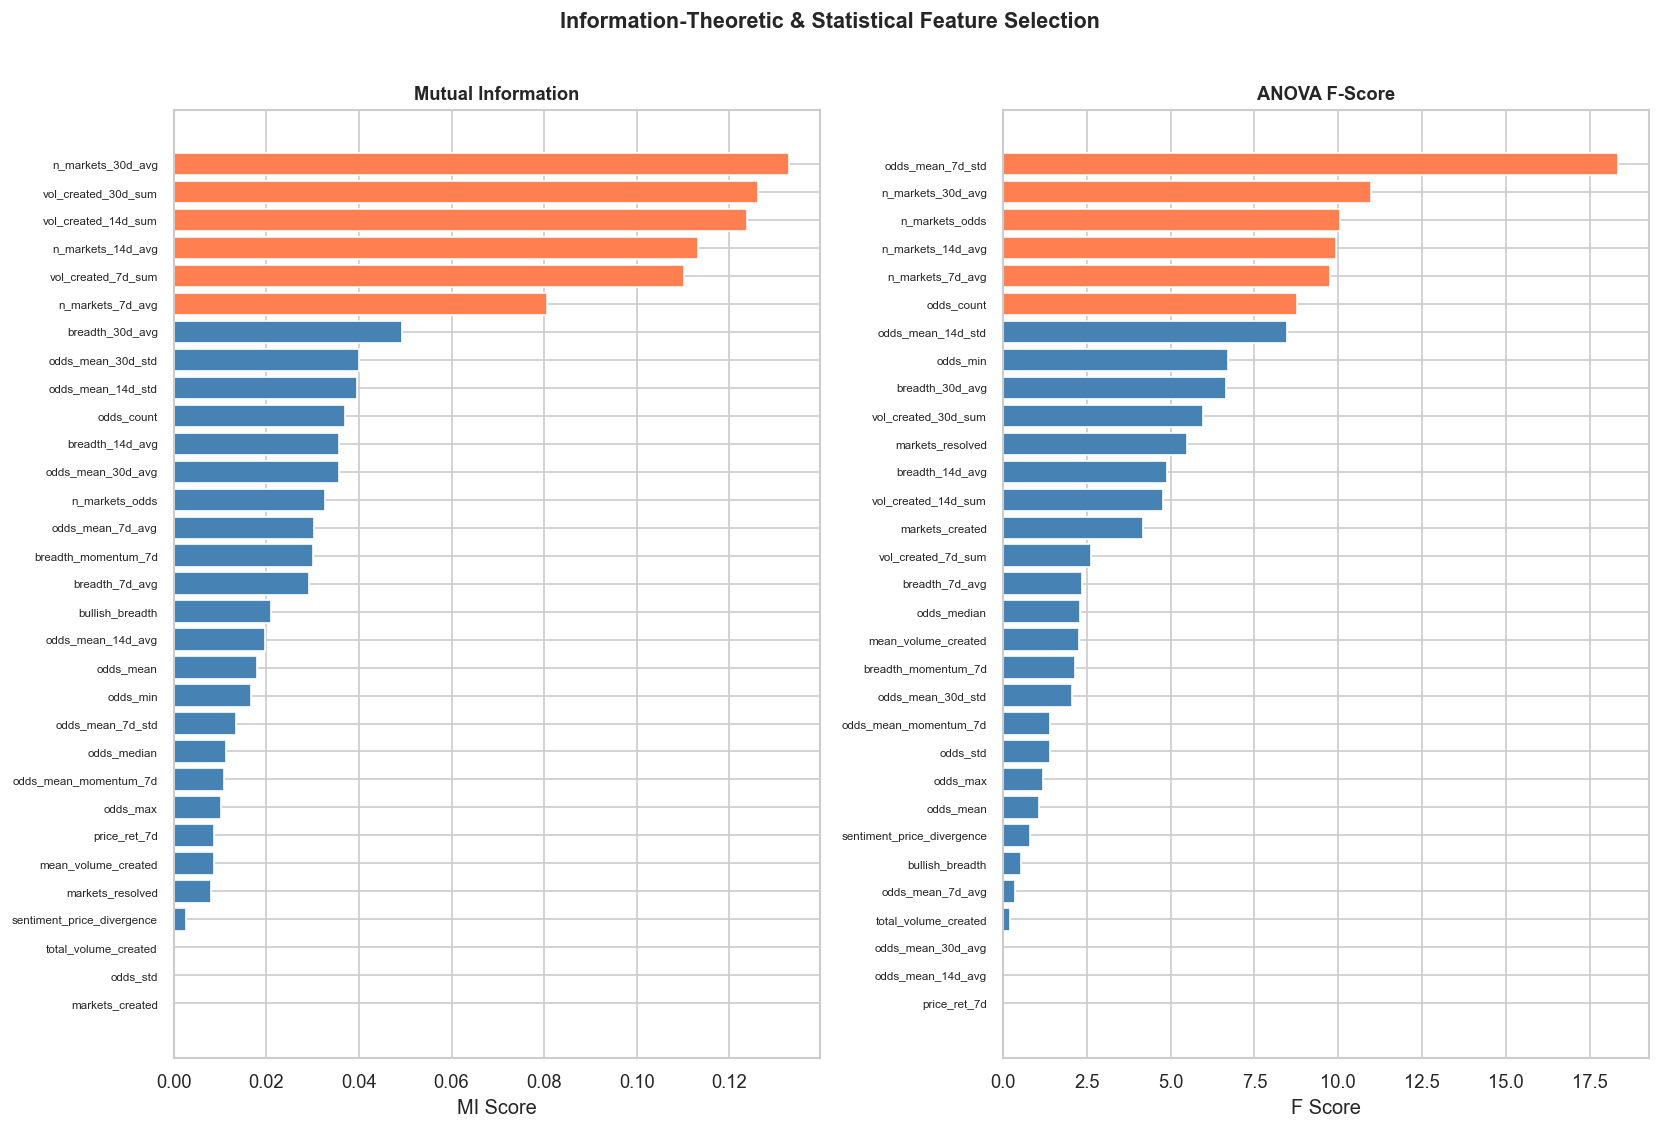

In [32]:
print("Part 3: Mutual Information & F-Test")
display(Image(filename=str(PLOTS_DIR / "part3_mi_ftest.png"), width=900))

Part 3: Lasso & ElasticNet Coefficients


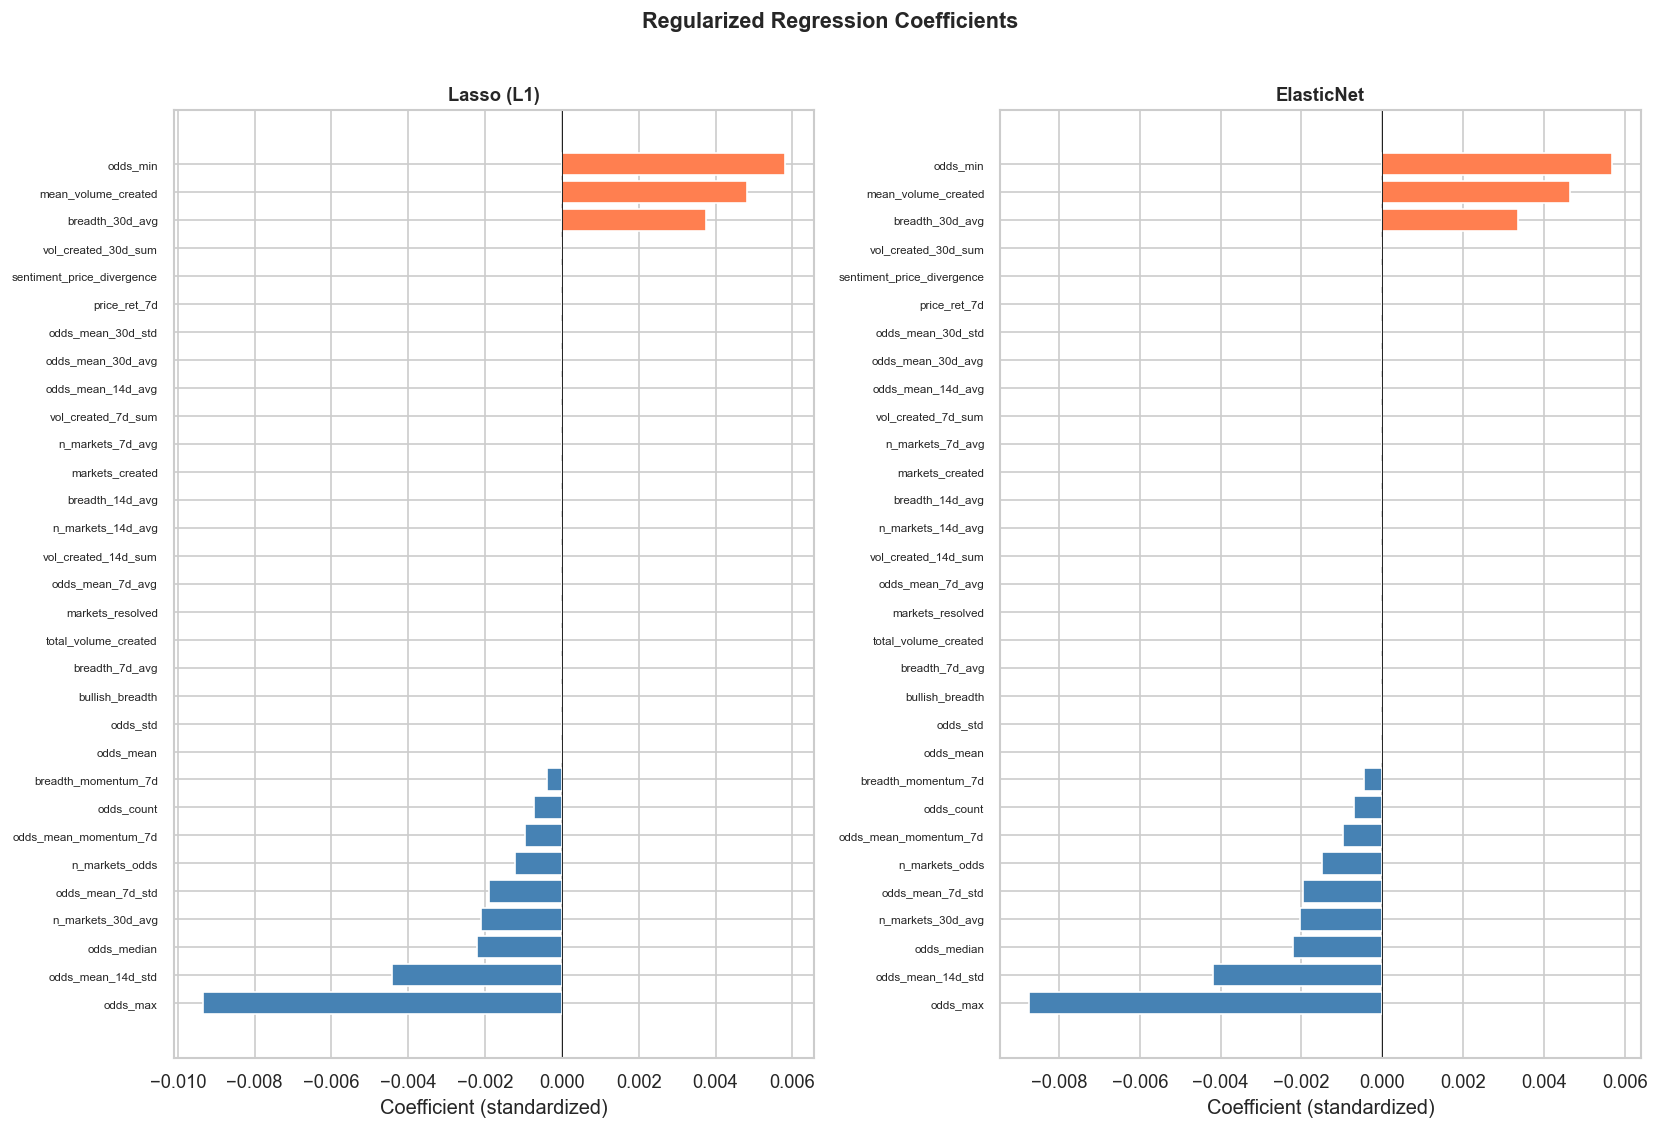

In [33]:
print("Part 3: Lasso & ElasticNet Coefficients")
display(Image(filename=str(PLOTS_DIR / "part3_lasso_elasticnet.png"), width=900))

Part 3: Lead/Lag Cross-Correlation


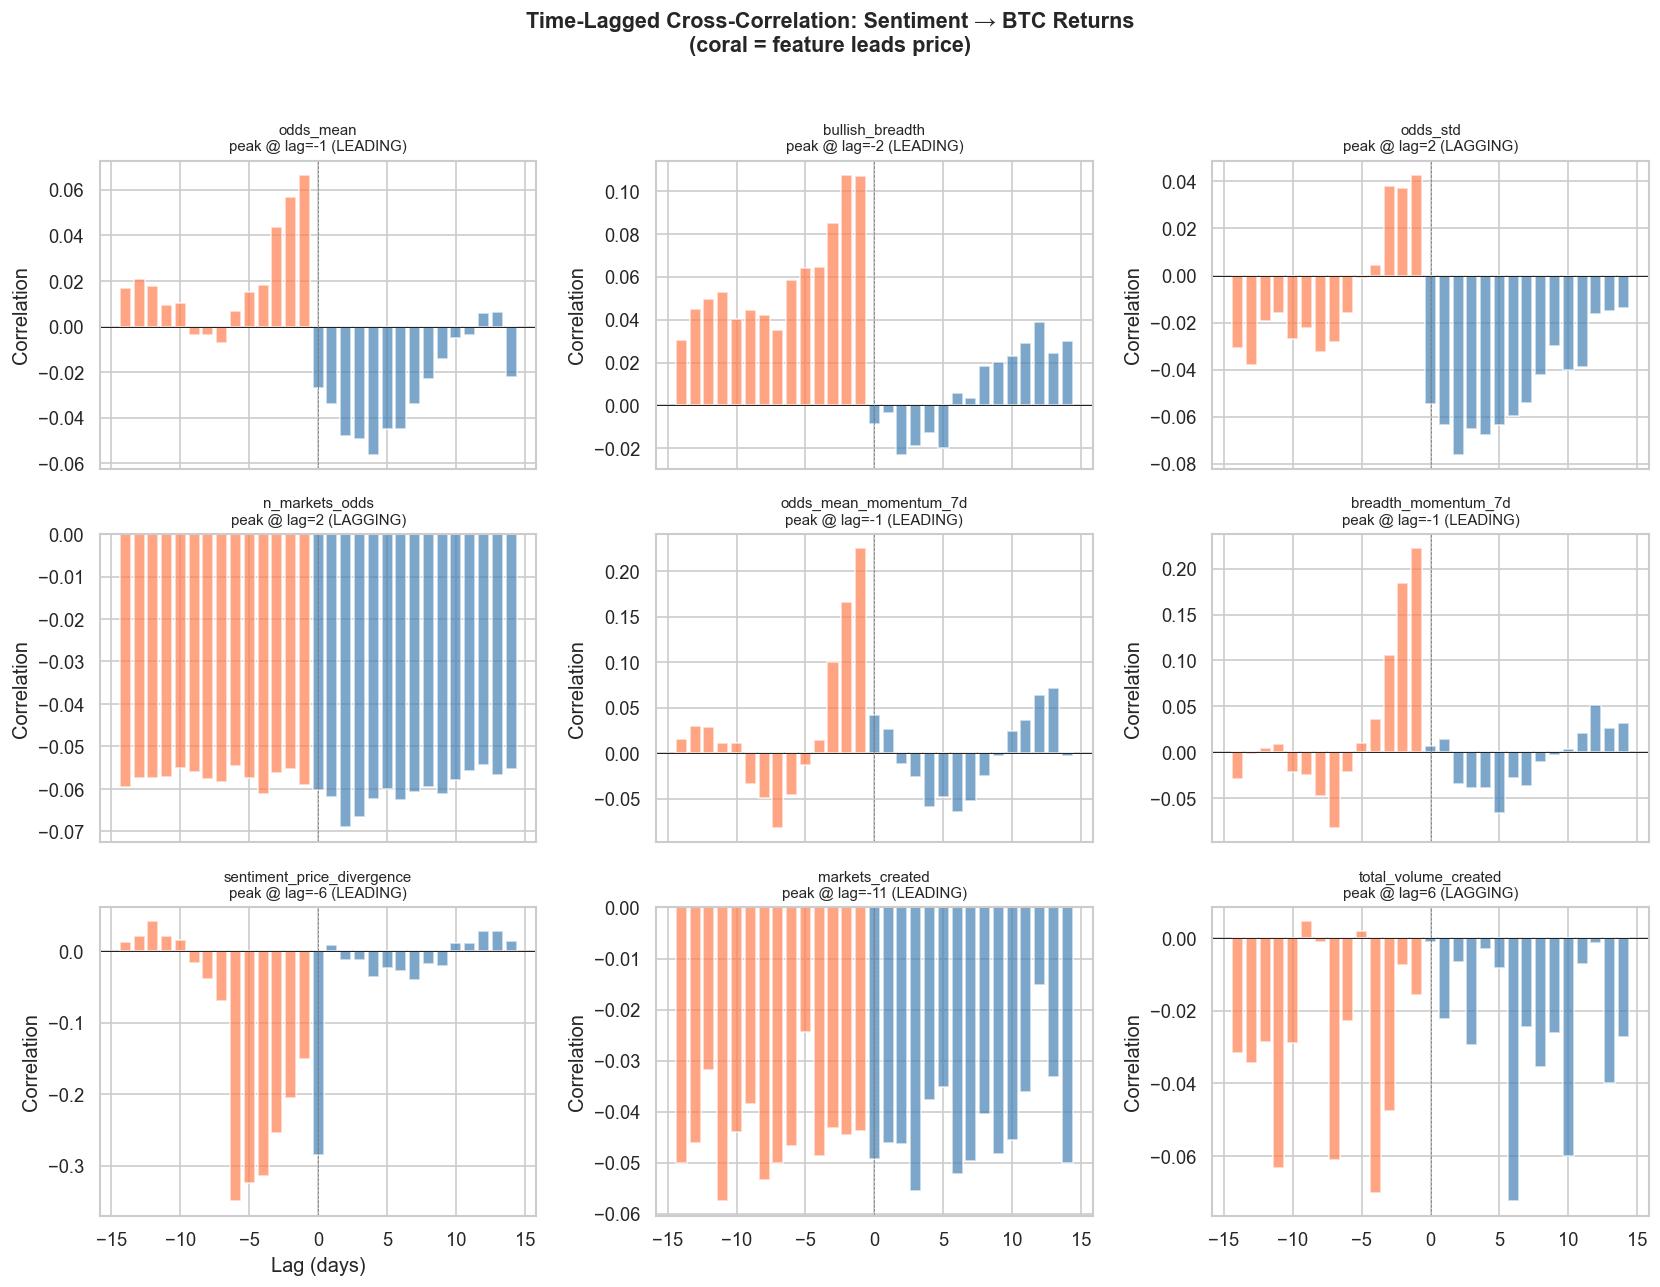

In [34]:
print("Part 3: Lead/Lag Cross-Correlation")
display(Image(filename=str(PLOTS_DIR / "part3_lag_crosscorr.png"), width=900))

---

## Conclusions

| # | Conclusion |
|---|------------|
| 1 | **Simple DCA works.** No timing trick reliably improves it over 15+ years of BTC history. |
| 2 | **MVRV is the strongest single signal** for dynamic buy sizing, but the improvement over uniform DCA is modest. |
| 3 | **Polymarket sentiment is promising but data-limited** (only 2023-2026). Leading indicators from lag analysis are the only actionable signals. Unlikely to be used in final model but worth monitoring. |

---

## Recommendations

1. **Use uniform DCA as the foundation.** Timing doesn't matter, pick any cadence & day and stick with it.
2. **Prioritize on-chain valuation signals.** Long data history and strongest predictive strength. Investigate remaining on-chain features.
3. **Treat Polymarket signals as experimental & possibly supplemental.** Only lead/lag analysis shows predictive strength.
4. **Build composite scoring with on-chain valuation signal focus.** Combine top on-chain and any strongly predictive sentiment signals. Backtest composite vs individual signals vs uniform DCA.

---

## Next Steps

### Phase 1: On-Chain Signal Prioritization
1. Compute all 8 candidate on-chain signals as daily time series with smoothing (14d/30d rolling)
2. Rank with five-method framework (Spearman, RF/GB, MI, Lasso, lag analysis) → 7d/30d forward returns
3. Build inter-signal correlation matrix → identify redundancy clusters
4. Select top 3–4 non-redundant signals for composite score

### Phase 2: Polymarket Sentiment: Incremental Value Test

**Data constraint:** Only 1,932 overlapping days (Oct 2020 to Jan 2026) vs 6,221 for on-chain. Polymarket BTC markets began Oct 2020, covers only one full bull/bear cycle. Signals should supplement, not replace, on-chain metrics.

**Incremental value test:**
- Re-run five-method ranking in overlap window so results are comparable on same timeframe
- Cross-correlate sentiment features vs on-chain signals
  - If |$\rho$| > 0.5 → they capture same info (redundant)
  - Alternatively may still show general sentiment value despite limited history
- Incremental $R^2$ test: regress forward returns on (a) on-chain only, (b) on-chain + sentiment → partial F-test

**Feature classification:**
- **Complementary:** low on-chain correlation + significant incremental $R^2$ → include
- **Redundant:** high on-chain correlation → exclude
- **Noise:** no incremental value → exclude
- Expected survivors: odds momentum, breadth momentum (led price in lag analysis)

**Key question to answer:** *Does Polymarket sentiment capture information about future BTC returns that is NOT already contained in on-chain metrics?*
- If yes → include as supplementary tilt in composite
- If no → document finding and omit from composite (simplicity > complexity)

### Phase 3: Composite Score Construction

| Approach | Method | Pros | Complexity |
|----------|--------|------|------------|
| **Equal-weight z-score** | Rolling 365d z-score per signal, simple average | Transparent & reproducible | Low |
| **Rank-weighted average** | Weight by five-method rank (top signals get higher weight) | Data-informed but interpretable | Moderate |
| **PCA factor score** | First principal component of top signals | Captures shared variance, maximally data-driven | High (overfitting risk) |

**Composite → Market State → Dynamic DCA**

**Validation & backtesting:**
- Walk-forward validation: train 2013–2021, validate 2021–2023, test 2023–2025 (avoid look-ahead bias)
- Benchmark: Composite DCA vs MVRV-only DCA vs Uniform DCA
- Metrics: Sharpe ratio, max drawdown, cost-basis improvement
- Sensitivity analysis on composite weights, market state thresholds (20th/80th vs 25th/75th vs 33rd/67th)